# Pipeline to visualize Spring Layouts in 2D with emphasizing specific genes (input: list of genes)

### LIBRARIES

In [2]:
from collections import (defaultdict,Counter)
from collections import defaultdict as dd
from collections import Counter as ct
from collections import OrderedDict
import colorsys
from colormap import rgb2hex, rgb2hls, hls2rgb
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from collections import Counter

from fisher import pvalue
from fa2 import ForceAtlas2

import itertools as it

from matplotlib import colors as mcolors
import math
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
import mygene

import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.generators.degree_seq import expected_degree_graph
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
import numba
#@numba.njit(fastmath=True)

import os
import os.path

import pandas as pd

import pickle
import plotly
import plotly.express as px
import plotly.graph_objs as pgo
import plotly.offline as py
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio

from prettytable import PrettyTable

import pylab

py.init_notebook_mode(connected = True)

import random as rd

from scipy.spatial import distance_matrix
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from scipy.spatial import distance_matrix
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection,cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import sys 

from tqdm import tqdm_notebook as tqdm
import time

### FUNCTIONS 

In [3]:
def draw_node_size(G, d_node_size, scalef):
    
    d_node_size_sorted = {key:d_node_size[key] for key in G.nodes()}    
    
    l_size = []
    for nd,val in d_node_size_sorted.items():
        R = scalef * (1 + val**1.1)      
        l_size.append(R)
        
    return l_size

In [18]:
def color_specific_nodes(G, l_nodes_o_be_coloured, colour, prefix = None):

    # assign colours to disease cat.(colour1) and other nodes(grey)
    d_col = {}
    for node in l_nodes_to_be_coloured:
        d_col[str(prefix)+str(node)] = colour
    
    d_rest = {}
    for i in G.nodes():
        if i not in d_col.keys():
            d_rest[i] = 'dimgrey'
        
    d_allnodes_col = {**d_col, **d_rest}
    d_allnodes_col_sorted = {key:d_allnodes_col[key] for key in G.nodes()}
    
    colours = list(d_allnodes_col_sorted.values())
    
    return colours

--------

### SCRIPT

In [10]:
data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
#df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']
G = G_cere

#edge_list = nx.write_edgelist(G, "Yeast_edgelist_directinteractiononly.txt")

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [11]:
# NETWORK DEFINED 
organism = 'Yeast' # this is useful for file naming
G = G_cere

### VISUALIZATION PARAMETERS

In [26]:
# N O D E   C O L O R S 

# ---------------------------------
# define a list of genes here: 
# ---------------------------------
name = 'specific genes for ...' # this is useful for naming images 
prefix = 'entrez gene/locuslink:' # necessary if G.nodes not only number, but also include some specific text (depending on network), for human PPI : prefix = None

l_nodes_to_be_coloured = list(ess_id)
list_of_all_nodes_coloured = color_specific_nodes(G, l_nodes_to_be_coloured, 'red', prefix)


# N O D E  S I Z E 

#degs = G.degree()
#node_factor = 2
#size = draw_node_size(G, degs, node_factor) # node size based on degree
size = 10
opacity_nodes = 1
node_edge_col = list_of_all_nodes_coloured


# E D G E S 

edge_color = 'grey'
edge_width = 0.1
opacity_edges = 0.3

In [29]:
posG_spring = nx.spring_layout(G)

Network:  Yeast
Number of Nodes: 5785


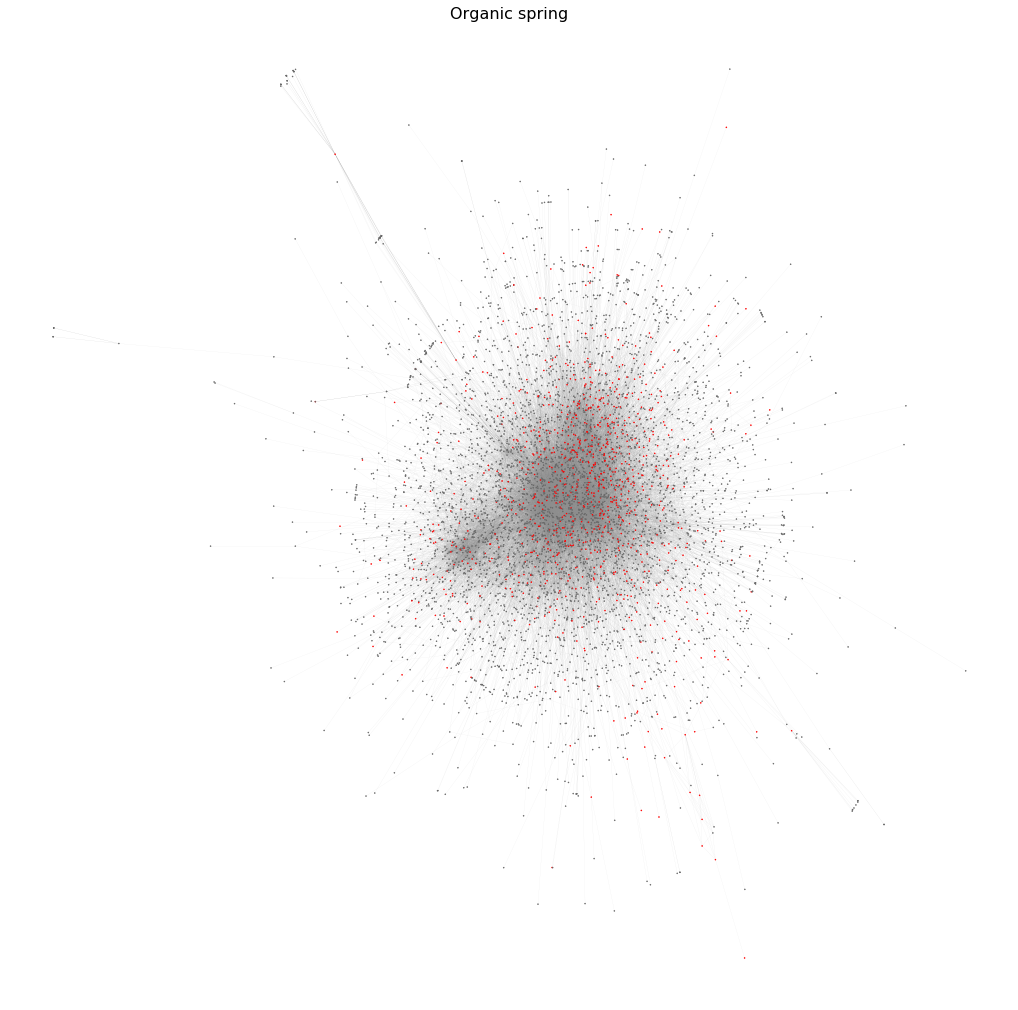

In [30]:
plt.figure(figsize=(18,18))
plt.box(False)
nx.draw_networkx_nodes(G, posG_spring,
                       edgecolors = node_edge_col, 
                       linewidths = 0.5, 
                       node_size=1, 
                       node_color = list_of_all_nodes_coloured)
nx.draw_networkx_edges(G, pos = posG_spring, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
print('Network: ', organism)
print('Number of Nodes:', len(G.nodes()))

plt.savefig('2Dspring_'+organism+'_'+name+'.png')
plt.show()